In [2]:
# Written by David Gontier
# 29/09/2022

reset

Nothing done.


# 1d Case

In 1d, the Dirac operator is
$$
    D_m = \begin{pmatrix}
        m & \partial_x \\ -\partial_x & -m
    \end{pmatrix}.
$$
We want to find the optimizers of
$$
    \inf \left\{ \langle \phi, K_W(\lambda) \phi \rangle,  \quad \| \phi \|_{L^2} = 1, \quad \| W \|_{L^p} = 1 \right\}.
$$
with $1 < p \le \infty$ and
$$
    K_W(\lambda) := \sqrt{W}  R_0(\lambda) \sqrt{W}, \quad \text{with} \quad R_0(\lambda) = (D_m - \lambda)^{-1} = \dfrac{1}{-\Delta + m^2 - \lambda^2} (D_m + \lambda)
$$


In [1]:
%pylab inline
import scipy.sparse.linalg as LA
import scipy.special as special

Populating the interactive namespace from numpy and matplotlib


In [2]:
## The grid to compute the Lp integrals
a = 5                      # we compute quantities on the interval [-a, a]
Nb = 1000                    # number of discretization points. Must be even
xx = linspace(-a, a, Nb+1)    # The grid
xx = xx[:Nb]
eps = xx[1] - xx[0]         # the step

## The Lp-nor

def Lp_norm(f, p):
    if len(f) == 2*Nb:
        # f is a 2*Nb vector. The first Nb entries are for spin up, and the Nb second ones for spin down
        f_up, f_dofn = f[:Nb], f[Nb:]
        absv = sqrt(abs(f_up)**2 + abs(f_dofn)**2)
        integral = sum(absv**p)*eps
        return integral**(1/p)
    else: # for the potential
        integral = sum(abs(f)**p )*eps
        return integral**(1/p)

We compute the Dirac operator (and its inverse), in Fourier space. Writing (with Python convention)
$$
    f(x) = \sum_{k=-M}^M f_k \exp ( - i k \frac{2 \pi }{2 a} x),
$$
we access the coefficients $f_k$ with `fft.fft(v)` (and some shifts), and the operator $(- i \partial_x)$ becomes the multiplication by $-\frac{\pi}{a} k$.

In [4]:
m = 1 # the mass

######################################
def get_Dirac(Nb, λ = 0):
    # returns the operator (Dirac - λ)

    K = pi/a* roll( arange(-Nb//2+1, Nb//2+1), Nb//2 +1) # Fourier modes (with the correct shift)

    def mult_Dirac(w):
        w_up, w_down = w[:Nb], w[Nb:]

        w_up_fft, w_down_fft = fft.fft(w_up), fft.fft(w_down)
        
        res_up_fft = (m - λ)*w_up_fft + 1j*K*w_down_fft
        res_down_fft = -1j*K*w_up_fft - (m + λ)*w_down_fft

        res = zeros(2*Nb, dtype='complex')
        res[:Nb] = fft.ifft(res_up_fft)
        res[Nb:] = fft.ifft(res_down_fft)

        return res
    return LA.LinearOperator((2*Nb, 2*Nb), matvec = mult_Dirac)

#########################################
def get_Dirac_inverse(Nb, λ = 0):
    # returns the operator (Dirac - λ)^{-1}

    K = pi/a* roll( arange(-Nb//2+1, Nb//2+1), Nb//2 +1) # Fourier modes

    def mult_Dirac(w):
        w_up, w_down = w[:Nb], w[Nb:]

        w_up_fft, w_down_fft = fft.fft(w_up), fft.fft(w_down)
        
        res_up_fft = (m + λ)*w_up_fft + 1j*K*w_down_fft
        res_down_fft = -1j*K*w_up_fft - (m - λ)*w_down_fft

        res_up_fft *= 1/(K**2 + m**2 - λ**2)
        res_down_fft *= 1/(K**2 + m**2 - λ**2)

        res = zeros(2*Nb, dtype='complex')
        res[:Nb] = fft.ifft(res_up_fft)
        res[Nb:] = fft.ifft(res_down_fft)

        return res
    return LA.LinearOperator((2*Nb, 2*Nb), matvec = mult_Dirac)

In [5]:
#################################
# Check cell

Dirac, Dirac_m1 = get_Dirac(Nb), get_Dirac_inverse(Nb)

print("Check self-adjointness")
u = rand(2*Nb) + 1j*rand(2*Nb)
v = rand(2*Nb) + 1j*rand(2*Nb)
print("\t must be 0 : ", norm ( dot(conj(u),Dirac@v) - dot(conj(Dirac@u), v)) )

print("Check invertibility")
u = rand(2*Nb) + 1j*rand(2*Nb)
print("\t must be 0 : ", norm ( Dirac_m1@(Dirac@u) - u ) )

print("Check Dirac")
w = zeros(2*Nb)
w[Nb:] = exp(-xx**2) # Gaussian in spin down
print("\t must be 0 : ", norm (-2*xx*exp(-xx**2) - (Dirac@w)[:Nb] ) )

Check self-adjointness
	 must be 0 :  1.368970808788651e-12
Check invertibility
	 must be 0 :  6.808993347321293e-14
Check Dirac
	 must be 0 :  1.751425581757078e-10


We compute the infimum problem with a self-consistent loop. We set $\phi_n$ the highest normalized eigenvector of $K_{W_n}(\lambda)$, and set
$$
    W_{n+1} = | \phi_n |^{2/p}.
$$

In [6]:
def get_W(phi, p):
    phi_up, phi_down = phi[:Nb], phi[Nb:]
    W = (abs(phi_up)**2 + abs(phi_down)**2)**(1/p)
    # Shift to center
    imax = argmax(W)
    W = roll(W, -imax+ Nb//2 )
    return W

def get_KW(W):
    def mult_op(phi):
        sqrtW = zeros(2*Nb)
        sqrtW[:Nb] = W**(1/2)
        sqrtW[Nb:] = W**(1/2)

        phi1 = sqrtW*phi
        phi2 = Dirac_m1@phi1
        phi3 = sqrtW*phi2
        return phi3
    
    return LA.LinearOperator((2*Nb, 2*Nb), matvec = mult_op)

def energy(KW, phi):
    return real( dot(conj(phi), KW@phi)*eps )

In [7]:
p = 1.5
λ = 0.5

# Initialization vector
phi0 = zeros(2*Nb, dtype='complex')
phi0 = rand(2*Nb) #+ 1j*rand(2*Nb)
phi0 = phi0/Lp_norm(phi0, 2)
W0 = get_W(phi0, p)

# Parameters of the loop
Niter = 100    # maximal number of iterations
tol = 1e-7      # tolerance

################################
Dirac, Dirac_m1 = get_Dirac(Nb, λ), get_Dirac_inverse(Nb, λ)

#################################
# Main loop
En, Wn, phin = -1, W0, phi0

for n in range(Niter):
    KWn = get_KW(Wn)
    eigval, eigvec = LA.eigsh(KWn, k=1, which='LA') #largest eigenvector
    
    phinp1, Enp1 = eigvec[:,0], eigval[0]
    phinp1 = phinp1/Lp_norm(phinp1, 2)

    if Enp1 < En:
        print("problem, the energy is not increasing...")
        break

    Wnp1 = get_W(phinp1, p)
    if norm(Wnp1 - Wn) < tol:
        break

    if mod(n, 10) == 0: #print
        print("Iteration n = {:4}, Energy = {}, norm = {}".format(n, En, norm(Wnp1 - Wn)),)

    En, Wn, phin = Enp1, Wnp1, phinp1


phistar, Wstar, tau = phin, Wn, Enp1
print("\nDone. Number of iterations = {}, Energy = {:.4}, tau = {:.4}".format(n, En, tau))


Iteration n =    0, Energy = -1, norm = 3.7949451520884887
Iteration n =   10, Energy = 0.7617834372833187, norm = 0.24175810520394964
Iteration n =   20, Energy = 0.7658825146502413, norm = 0.020368249254990076
Iteration n =   30, Energy = 0.7659085231757427, norm = 0.001746697144008299
Iteration n =   40, Energy = 0.7659087057460732, norm = 0.00014816603269451412
Iteration n =   50, Energy = 0.765908707038642, norm = 1.2507868679789377e-05
Iteration n =   60, Energy = 0.7659087070478013, norm = 1.0540299543561219e-06
problem, the energy is not increasing...

Done. Number of iterations = 68, Energy = 0.7659, tau = 0.7659


norm W =  0.9999999999999999
max W =  1.1477630167548434


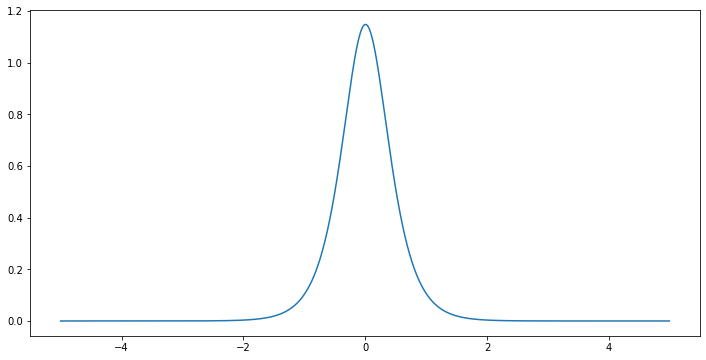

In [8]:
# Plot the best potential

figsize(12, 6)

plot(xx, Wstar)
print("norm W = ", Lp_norm(Wstar, p))
print("max W = ", max(Wstar))

## The "true" solution






The function $\phi$ satisfies (recall that $W = | \phi |^{2/p}$)
$$
    | \phi |^{1/p} R_0(\lambda) | \phi |^{1/p} \phi = \tau \phi, \quad \text{hence} \quad R_0(\lambda) | \phi |^{1/p} \phi = \tau | \phi |^{-1/p} \phi
$$
We set $\psi = \tau^{(1-p)/2} | \phi |^{-1/p} \phi$, so that $\phi = \tau^{(p-1)/2} | \psi |^{1/(p-1)} \psi$
$$
    (D_m - \lambda) \psi = V \psi \quad \text{with} \quad V = | \psi |^{\frac{2}{p-1}}.
$$

In [9]:
# Check cell
W2 = zeros(2*Nb, dtype="complex")
W2[:Nb] = Wstar
W2[Nb:] = Wstar

psi = tau**((1-p)/2)*W2**(-1/2)*phistar
psi_up, psi_down = psi[:Nb], psi[Nb:]
V = (abs(psi_up)**2 + abs(psi_down)**2)**(1/(p-1))
V2 = zeros(2*Nb, dtype="complex")
V2[:Nb] = V
V2[Nb:] = V

print("must be 0: ", norm (Dirac@psi - V2*psi))

must be 0:  6.327937637370523e-07


# Comparison with theory

We proved that the *original* potential $V = | \Psi |^{\frac{1}{p-1}}$ must be of the form (1d case)
$$
    V(x) = \frac{A}{B} Z \left( \frac{2A}{pB} x  \right)
$$
with $A = \frac{m + \lambda}{2 m}$,  $B = \frac{p-1}{2mp}$ and
$$
    Z(x) :=  \dfrac{2 Z_0}{(Z_0 + 1) \cosh(\sqrt{Z_0} x) - Z_0 + 1} \quad Z_0 = \frac{1 - A}{A}
$$

In [10]:
#depends on m, p, and λ
A = (m + λ)/2/m
B = (p-1)/2/m/p
Z0 = (1-A)/A

def Z(x): return 2*Z0/((Z0+1)*cosh(x*sqrt(Z0)) - Z0 + 1)

Vth =  A/B*Z(2*A/p/B*xx)
print("must be 0 : ", norm (V - Vth))

must be 0 :  0.08037054810693424


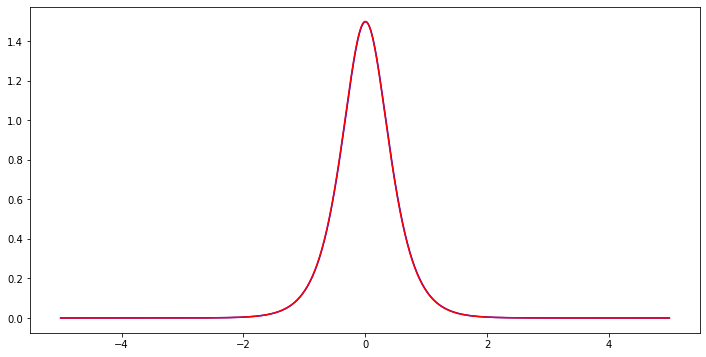

In [11]:
# Comparison of the two potentials

plot(xx, V, 'b')  # the computed potential
plot(xx, Vth, 'r') # the theoretical potential

# With ODE techniques

We write $\psi = (v,u)$, and we want to solve the equation
$$
    \begin{cases}
        v' = - \left( (\lambda + m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) u \\
        u' =   \left( (\lambda - m) + (| u |^2 + | v |^2)^{\frac{1}{p-1}}  \right) v
    \end{cases}
$$

In [12]:
from scipy.integrate import solve_ivp

def f(t, y):
    v, u = y
    V = (u**2 + v**2)**(1/(p-1))
    dv = - ((λ+m) + V)*u
    du = ((λ-m) + V)*v
    return array([dv, du])

In [13]:
tt = linspace(1e-8, 2*a, 100)

def solve_with_v0(v0):
    sol = solve_ivp(f, t_span=[1e-8, 2*a], y0 = [v0, 0], t_eval=tt)
    return sol.y

In [14]:
# We find the best initial condition with a dichotomy
def find_psi_ode():
    vmin, vmax = 1/2, 2 # a simple dichotomy
    for n in range(30):
        v0 = (vmin + vmax)/2
        v, u = solve_with_v0(v0)

        # if good precision
        if norm (vmax - vmin) < 1e-7:
            print("v0 = ", v0)
            return v, u
        
        # else dichotomy
        if min(v) < 1e-3: # the solution becomes negative: v0 is too high
            vmin, vmax = vmin, v0
        else: 
            vmin, vmax = v0, vmax
        print(vmin, vmax)
    print("problem")
    return v, u
        

In [15]:
v, u = find_psi_ode()

0.5 1.25
0.875 1.25
1.0625 1.25
1.0625 1.15625
1.0625 1.109375
1.0859375 1.109375
1.09765625 1.109375
1.103515625 1.109375
1.1064453125 1.109375
1.1064453125 1.10791015625
1.1064453125 1.107177734375
1.1068115234375 1.107177734375
1.1068115234375 1.10699462890625
1.1068115234375 1.106903076171875
1.1068115234375 1.1068572998046875
1.1068115234375 1.1068344116210938
1.1068229675292969 1.1068344116210938
1.1068286895751953 1.1068344116210938
1.1068315505981445 1.1068344116210938
1.1068329811096191 1.1068344116210938
1.1068329811096191 1.1068336963653564
1.1068333387374878 1.1068336963653564
1.1068335175514221 1.1068336963653564
1.1068335175514221 1.1068336069583893
v0 =  1.1068335622549057


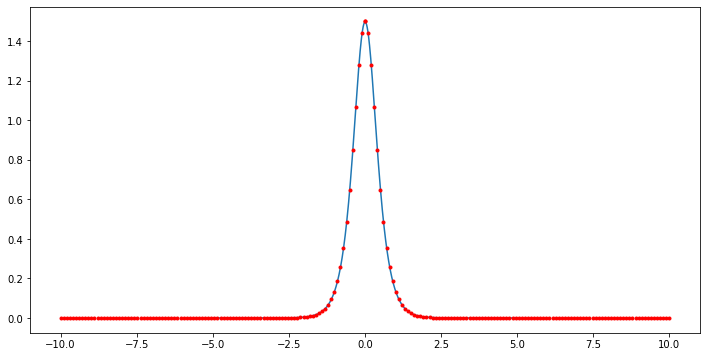

In [16]:
# Check ODE versus minimization
plot(xx, V)
plot(tt, (abs(v)**2 + abs(u)**2)**(1/(p-1)), '.r')
plot(-tt, (abs(v)**2 + abs(u)**2)**(1/(p-1)), '.r')
